In [73]:
#
# Copyright 2022 Jiayi Hoffman. All Rights Reserved.
#

In [1]:
import numpy as np
import time
import datetime

import PIL.Image as Image
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

%matplotlib inline
%load_ext tensorboard

#### Load and batch the data

In [2]:
import os

# load image data from directory
PATH = '../images'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_ds_original = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

val_ds_original = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_ds_original = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

class_names = train_ds_original.class_names

Found 38 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


2022-01-18 16:01:59.805686: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 10 files belonging to 2 classes.


In [ ]:
# explore the data
class_names = np.array(train_ds_original.class_names)
print(class_names)

# preprocess the data. xxxJiayi, instead of a step in the preprocessing pipeline, this is now part of the model layer. This simplifies the model test and consumption. 
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# train_ds = train_ds_original.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
# val_ds = val_ds_original.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
# test_ds = test_ds_original.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

# prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_original.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_original.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds_original.cache().prefetch(buffer_size=AUTOTUNE)


#### transfer learning from an existing Mobilenet model

In [4]:
def draw_learning_curves(acc, val_acc, loss, val_loss, draw_finetune_line=False):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')   
    plt.ylim([min(plt.ylim()), 1])
    if draw_finetune_line:
        plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 1.0])
    if draw_finetune_line:
        plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.ylabel('Cross Entropy')
    
    plt.show() 


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1024)              1026552   
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 1,028,602
Trainable params: 2,050
Non-trainable params: 1,026,552
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 5s 1s/step - loss: 0.8773 - accuracy: 0.4737 - val_loss: 0.6272 - val_accuracy: 0.6250
Epoch 2/10
2/2 [==============================] - 1s 699ms/step - loss: 0.6675 - accuracy: 0.6842 - val_loss: 0.5357 - val_accuracy: 0.6250
Epoch 3/10
2/2 [===========

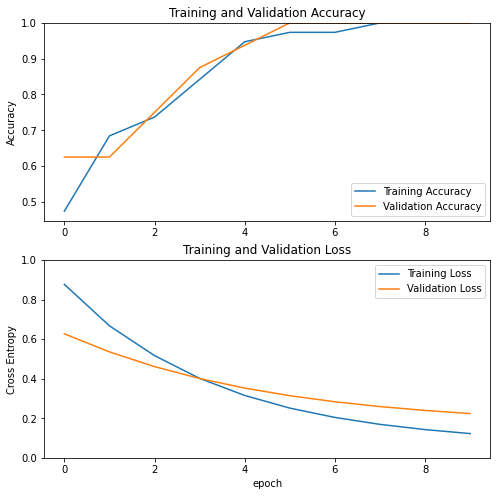

In [5]:
# download the feature vector model, which is also known as "headless model". it does not have the top sigmoid layer
mobilenet_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5"
mobilenet_v2 = "https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://hub.tensorflow.google.cn/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v3

IMG_SHAPE = IMG_SIZE + (3,)
# use trainable=False to keep weights stable, so that the training only modifies the new layer
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=IMG_SHAPE,
    trainable=False)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

normalization_layer = tf.keras.layers.Rescaling(1./255)

num_classes = len(class_names)
model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SHAPE),
    normalization_layer,
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.summary()

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])
# activation="softmax" and "from_logits=True" in the loss funciton are mutually exclusive. remove "from_logits", and use "softmax"
# See the explaination in https://datascience.stackexchange.com/questions/73093/what-does-from-logits-true-do-in-sparsecategoricalcrossentropy-loss-function

# configure the tensorboard
log_dir = "logs/myfit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
draw_learning_curves(acc, val_acc, loss, val_loss)

%tensorboard --logdir logs/myfit

#### Evaluate the model using the test set

In [25]:
def show_image_prediction(image_batch, predicted_batch, label_batch):
    num_images = len(image_batch)
        
    plt.figure(figsize=(15, 15))
    plt.suptitle("Predictions")
    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(image_batch[i].astype("uint8")) # pyplot requires integer type for image data value between [0, 255]
        
        title = 'pred:{}, label:{}'.format(class_names[predicted_batch[i]], class_names[label_batch[i]])
        color = 'black'
        if predicted_batch[i] != label_batch[i]:
            color= 'red'
        
        plt.title(title, color=color)
        plt.axis('off')
    plt.show()  

In [26]:
# predict using the transfered model
def predict(ds):
    image_batch, label_batch = ds.as_numpy_iterator().next()
    print('image batch shape:', image_batch.shape)
    print('label batch shape:', label_batch.shape)

    predictions = model.predict_on_batch(image_batch)   
    print('predicted_batch shape', predictions.shape)

    predicted_ids = tf.math.argmax(predictions, axis=-1)
    
    show_image_prediction(image_batch, predicted_ids, label_batch)

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

predict(test_ds)


In [39]:
# test an individual picture
def predict_one_image(a_model, image_path):
    # using keras preprocessing package
    img = tf.keras.preprocessing.image.load_img(image_path, target_size = IMG_SHAPE)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

    img = np.array(img)/255.0
    result = a_model.predict(img[np.newaxis, ...])
    print(result)

    # top_indices = tf.math.top_k(result[0], k=2).indices
    # print('Predicted: ', [imagenet_labels[index] for index in top_indices])

    predicted_id = tf.math.argmax(result[0], axis=-1)
    predicted_class_name = class_names[predicted_id]
    print(predicted_class_name)


#### Save the model for serving

In [50]:
# save the model
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
mobilenet_save_path = os.path.join("saved_models/image_classification/", timestamp)
tf.saved_model.save(model, mobilenet_save_path)


INFO:tensorflow:Assets written to: saved_models/image_classification/20220118-175757/assets


INFO:tensorflow:Assets written to: saved_models/image_classification/20220118-175757/assets


In [51]:
# load the saved model, and make sure it works as it was
loaded = tf.saved_model.load(mobilenet_save_path)
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

img = tf.keras.utils.load_img(img_path, target_size=IMG_SHAPE)
x = tf.keras.utils.img_to_array(img)
x = tf.keras.applications.mobilenet.preprocess_input(
    x[tf.newaxis,...])
labeling = infer(tf.constant(x))[model.output_names[0]]
print(labeling)

predicted_id = tf.math.argmax(labeling[0], axis=-1)
print(class_names[predicted_id])

['serving_default']
{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}
tf.Tensor([[0.56550014 0.43449977]], shape=(1, 2), dtype=float32)
Mars


### Convert the Keras model to TFLite

#### Convert from a saved model (recommended)

In [66]:
def write_tflite_model_to_file(tflite_model):
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tflite_model_path = os.path.join('./tflite_models/image_classification/', timestamp+'.tflite')
    
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(mobilenet_save_path)
tflite_model = converter.convert()
write_tflite_model_to_file(tflite_model)


2022-01-18 21:49:42.407176: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-01-18 21:49:42.407190: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-01-18 21:49:42.407193: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.
2022-01-18 21:49:42.407283: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: saved_models/image_classification/20220118-175757
2022-01-18 21:49:42.417487: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-01-18 21:49:42.417496: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: saved_models/image_classification/20220118-175757
2022-01-18 21:49:42.464317: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2022-01-18 21:49:42.762962: I tensorflow/cc/saved_model/loader.cc:194] Running i

#### Convert directly from a Keras Model 

In [69]:
# Convert the model.
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model2 = converter2.convert()
write_tflite_model_to_file(tflite_model2)


INFO:tensorflow:Assets written to: /var/folders/vt/hy4b4qm96lgft4mpdx1b8p1r0000gn/T/tmpquyccsqp/assets


INFO:tensorflow:Assets written to: /var/folders/vt/hy4b4qm96lgft4mpdx1b8p1r0000gn/T/tmpquyccsqp/assets
2022-01-18 21:51:39.518996: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-01-18 21:51:39.519011: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-01-18 21:51:39.519106: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/vt/hy4b4qm96lgft4mpdx1b8p1r0000gn/T/tmpquyccsqp
2022-01-18 21:51:39.529942: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-01-18 21:51:39.529956: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /var/folders/vt/hy4b4qm96lgft4mpdx1b8p1r0000gn/T/tmpquyccsqp
2022-01-18 21:51:39.591524: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2022-01-18 21:51:39.896393: I tensorflow/cc/saved_model/loader.cc:194] Running initializatio

#### evaluate the tflite model using the test set

In [72]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model, ds):
    image_batch, label_batch = ds.as_numpy_iterator().next()

    # Initialize TFLite interpreter using the model.
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    input_tensor_index = interpreter.get_input_details()[0]["index"]
    output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.
    predictions = []
    for test_image in image_batch:
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_tensor_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        prediction = np.argmax(output()[0])
        predictions.append(prediction)

    # Compare prediction results with ground truth labels to calculate accuracy.
    accurate_count = 0
    for index in range(len(predictions)):
        if predictions[index] == label_batch[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(predictions)

    return accuracy


float_accuracy = evaluate_tflite_model(tflite_model, test_ds)
print('ftlite model accuracy = %.4f' % float_accuracy)


ftlite model accuracy = 0.9000
